In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
test_dir='/content/drive/My Drive/Colab Notebooks/test_data'
train_dir='/content/drive/My Drive/Colab Notebooks/train_data'
validation_dir='/content/drive/My Drive/Colab Notebooks/validation_data'

In [ ]:
import tensorflow as tf
#num_threads = 4  # Adjust based on your hardware capabilities
#tf.config.threading.set_intra_op_parallelism_threads(num_threads)
#tf.config.threading.set_inter_op_parallelism_threads(num_threads)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')  # Mount Google Drive

import tensorflow as tf

# Make sure this path is correct, you can verify it in Google Colab's file explorer
train_dir = '/content/drive/MyDrive/Validation/Train/Train'

# Creating a Dataset for the Training data
train = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=['Healthy', 'Powdery', 'Rust'],
    batch_size=16,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=0,
    crop_to_aspect_ratio=True
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1322 files belonging to 3 classes.


In [ ]:
test_dir='/content/drive/MyDrive/Validation/Test/Test'

test = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=['Healthy', 'Powdery', 'Rust'],
    batch_size=16,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=0,
    crop_to_aspect_ratio=True
)


Found 150 files belonging to 3 classes.


In [ ]:
val_dir='/content/drive/MyDrive/Validation/Validation'
validation = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = ['Healthy', 'Powdery', 'Rust'],
    batch_size = 16,
    image_size = (256, 256),
    shuffle = True,
    seed = 123,
    validation_split = 0,
    crop_to_aspect_ratio = True
)


Found 60 files belonging to 3 classes.


In [ ]:
print(train)
print(test)
print(validation)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>


In [ ]:

from tensorflow.keras.layers import Rescaling # Import the Rescaling class
scaler = Rescaling(1./255) # Defining scaler values between 0 to 1
# Rescaling datasets
train = train.map(lambda x, y: (scaler(x), y))
test = test.map(lambda x, y: (scaler(x), y))
validation = validation.map(lambda x, y: (scaler(x), y))

In [ ]:
# Creating data augmentation pipeline
augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomRotation(
        factor = (-.25, .3),
        fill_mode = 'reflect',
        interpolation = 'bilinear',
        seed = 123),


        tf.keras.layers.RandomBrightness(
        factor = (-.45, .45),
        value_range = (0.0, 1.0),
        seed = 123),

        tf.keras.layers.RandomContrast(
        factor = (.5),
        seed = 123),

    ]
)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()
# Assuming you want to use MirroredStrategy for multi-GPU training
strategy = tf.distribute.MirroredStrategy()

# Initiating model on GPU
with strategy.scope():
    model = Sequential()

    model.add(augmentation) # Adding data augmentation pipeline to the model

In [ ]:
# Initiating model on GPU

with strategy.scope():
    model.add(augmentation) # Adding data augmentation pipeline to the model

    # Feature Learning Layers
    model.add(Conv2D(32,                  # Number of filters/Kernels
                     (3,3),               # Size of kernels (3x3 matrix)
                     strides = 1,         # Step size for sliding the kernel across the input (1 pixel at a time).
                     padding = 'same',    # 'Same' ensures that the output feature map has the same dimensions as the input by padding zeros around the input.
                    input_shape = (256,256,3) # Input image shape
                    ))
    model.add(Activation('relu'))# Activation function
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (5,5), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3,3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, (5,5), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.3))

    model.add(Conv2D(512, (3,3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.3))

    # Flattening tensors
    model.add(Flatten())

    # Fully-Connected Layers
    model.add(Dense(2048))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(3, activation = 'softmax')) # Classification layer

In [ ]:
# Compiling model
model.compile(optimizer = tf.keras.optimizers.Adam(0.0001), # 1e-4
              loss = 'categorical_crossentropy', # Ideal for multiclass tasks
              metrics = ['accuracy']) # Evaluation metric


In [ ]:
!pip install tensorflow

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # Import necessary classes

# Defining an Early Stopping and Model Checkpoints
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                              patience = 5, mode = 'max',
                              restore_best_weights = True)

checkpoint = ModelCheckpoint('best_model.h5',
                            monitor = 'val_accuracy',
                            save_best_only = True)

In [ ]:
# Defining an Early Stopping and Model Checkpoints
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                              patience = 5, mode = 'max',
                              restore_best_weights = True)

checkpoint = ModelCheckpoint('best_model.h5',
                            monitor = 'val_accuracy',
                            save_best_only = True)

In [ ]:
# Training and Testing Model
try:
    history = model.fit(
        train, epochs = 50,
        validation_data = test,
        callbacks = [early_stopping, checkpoint])
except Exception as e:
    print("An error occurred:", e)

Epoch 1/50
83/83 [==============================] - ETA: 0s - loss: 4.1838 - accuracy: 0.5227

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


83/83 [==============================] - 936s 11s/step - loss: 4.1838 - accuracy: 0.5227 - val_loss: 15.9519 - val_accuracy: 0.3333
Epoch 2/50
83/83 [==============================] - 832s 10s/step - loss: 2.0253 - accuracy: 0.6180 - val_loss: 19.5304 - val_accuracy: 0.3333
Epoch 3/50
83/83 [==============================] - 814s 10s/step - loss: 1.2782 - accuracy: 0.6536 - val_loss: 17.2833 - val_accuracy: 0.3333
Epoch 4/50
83/83 [==============================] - 829s 10s/step - loss: 0.8140 - accuracy: 0.7095 - val_loss: 9.6878 - val_accuracy: 0.3333
Epoch 5/50
83/83 [==============================] - 822s 10s/step - loss: 0.6742 - accuracy: 0.7330 - val_loss: 8.7889 - val_accuracy: 0.3400
Epoch 6/50
83/83 [==============================] - 826s 10s/step - loss: 0.6344 - accuracy: 0.7678 - val_loss: 6.0251 - val_accuracy: 0.4067
Epoch 7/50
83/83 [==============================] - 811s 10s/step - loss: 0.5679 - accuracy: 0.7753 - val_loss: 8.7077 - val_accuracy: 0.4000
Epoch 8/50
83/

In [ ]:
import numpy as np

In [ ]:
model.load_weights('best_model.h5')

In [ ]:
preds = model.predict(validation)  # Running model on the validation dataset
val_loss, val_acc = model.evaluate(validation) # Obtaining Loss and Accuracy on the val dataset

print('\nValidation Loss: ', val_loss)
print('\nValidation Accuracy: ', np.round(val_acc * 100), '%')

4/4 [==============================] - 12s 2s/step - loss: 0.8885 - accuracy: 0.8667

Validation Loss:  0.8884514570236206

Validation Accuracy:  87.0 %


In [ ]:
# Creating subplot
fig = make_subplots(rows=1,
                    cols=2,
                    subplot_titles=['<b>Loss Over Epochs</b>', '<b>Accuracy Over Epochs</b>'],
                    horizontal_spacing=0.2)

# Loss over epochs
train_loss = go.Scatter(x=list(range(len(history.history['loss']))),
                        y=history.history['loss'],
                        mode='lines',
                        line=dict(color='rgba(0, 67, 162, .75)', width=4.75),
                        name='Training',
                        showlegend = False)

val_loss = go.Scatter(x=list(range(len(history.history['val_loss']))),
                      y=history.history['val_loss'],
                      mode='lines',
                      line=dict(color='rgba(255, 132, 0, .75)', width=4.75),
                      name='Test',
                      showlegend = False)


fig.add_trace(train_loss, row=1, col=1)
fig.add_trace(val_loss, row=1, col=1)

# Accuray over epochs
train_acc = go.Scatter(x=list(range(len(history.history['accuracy']))),
                       y=history.history['accuracy'],
                       mode='lines',
                       line=dict(color='rgba(0, 67, 162, .75)', width=4.75),
                       name='Training',
                       showlegend = True)

val_acc = go.Scatter(x=list(range(len(history.history['val_accuracy']))),
                     y=history.history['val_accuracy'],
                     mode='lines',
                     line=dict(color='rgba(255, 132, 0, .75)', width=4.75),
                     name='Test',
                     showlegend = True)


fig.add_trace(train_acc, row=1, col=2)
fig.add_trace(val_acc, row=1, col=2)

# Define background colors
bg_color = 'white'  # Example background color
paper_color = 'white' # Example paper color

# Updating layout
fig.update_layout(
    title={'text': '<b>Loss and Accuracy Over Epochs</b>', 'x': 0.025, 'xanchor': 'left'},
    margin=dict(t=100),
    plot_bgcolor=bg_color,paper_bgcolor=paper_color, # Use the defined variables
    height=500, width=1000,
    showlegend= True
)

fig.update_yaxes(title_text = 'Loss', row = 1, col = 1)
fig.update_yaxes(title_text = 'Accuracy', row = 1, col = 2)

fig.update_xaxes(title_text = 'Epoch', row = 1, col = 1)
fig.update_xaxes(title_text = 'Epoch', row = 1, col = 2)

# Showing figure
fig.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
!pip install plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots  # Import make_subplots

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (Batch  (None, 256, 256, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)     

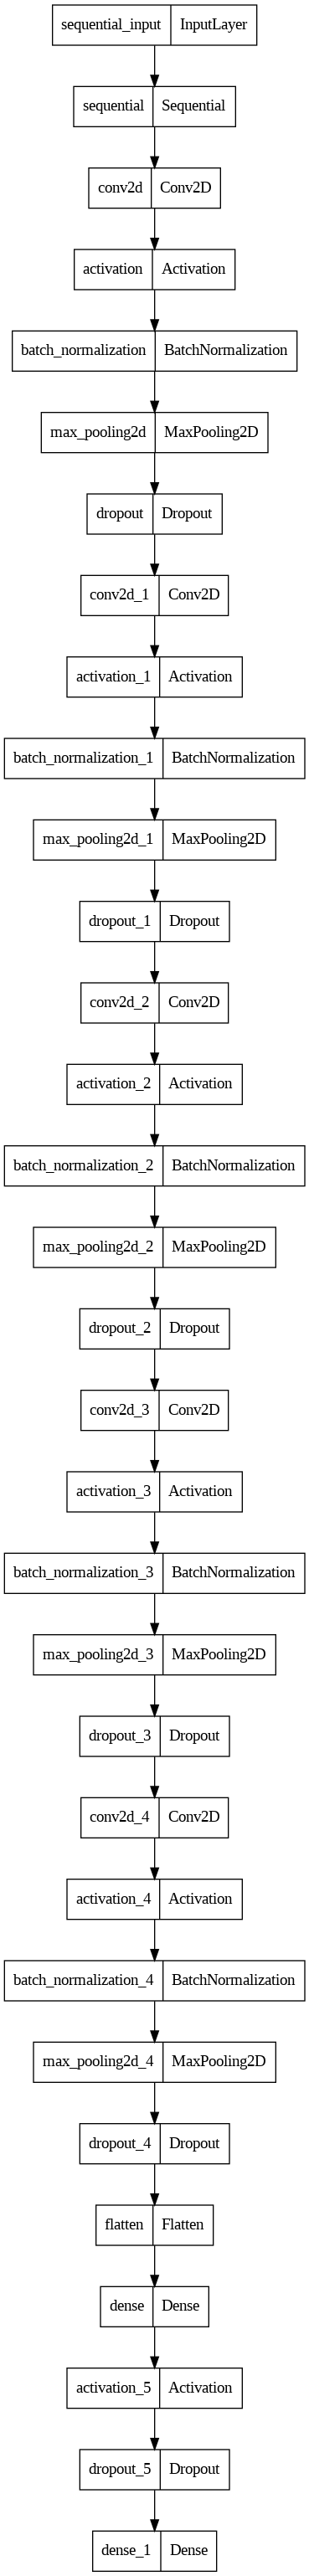

In [ ]:
tf.keras.utils.plot_model(model) # Plotting model

In [ ]:
model.load_weights('best_model.h5')

Picture of a powder plant: 



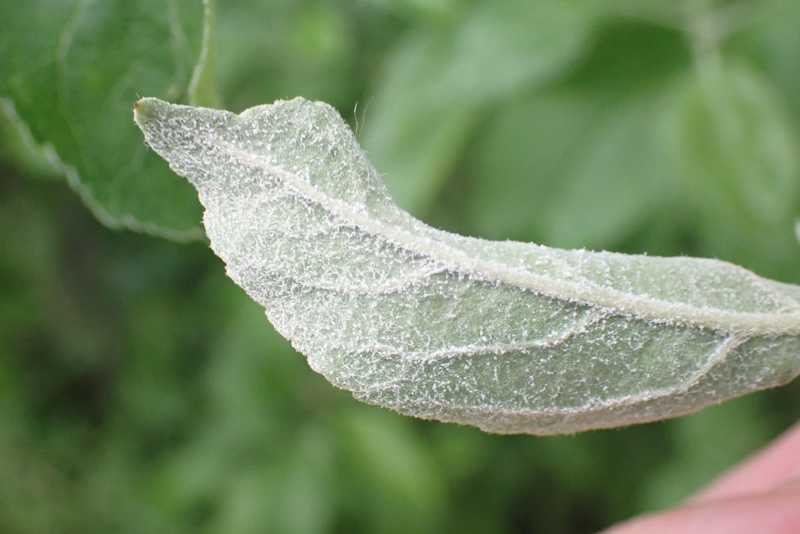

In [ ]:
# Loading an image from the Validation/ Powdery directory
image_path = '/content/drive/MyDrive/Validation/Validation/Powdery/8fd27998ae52a4a6.jpg'
original_image = Image.open(image_path)
og_width, og_height = original_image.size

# Resizing image for optimal performance
new_width = int(og_width * .20) # 20% of the original size
new_height = int(og_height * .20) # 20% of the original size

resized_img = original_image.resize((new_width, new_height))
print('Picture of a powder plant: \n')
resized_img

In [ ]:
from PIL import Image # Import Image from PIL


In [ ]:
# Manually preprocessing image
preprocessed_image = original_image.resize((256, 256))
preprocessed_image = np.array(preprocessed_image) / 255.0

preds = model.predict(np.expand_dims(preprocessed_image, axis = 0))
labels = ['Healthy', 'Powdery', 'Rust']

preds_class = np.argmax(preds)
preds_label = labels[preds_class]

print(f'\nPredicted Class: {preds_label}')
print(f'\nConfidence Score: {preds[0][preds_class]}')

1/1 [==============================] - 0s 230ms/step

Predicted Class: Powdery

Confidence Score: 1.0


In [ ]:
model.save('plant_disease_classifier.h5') # Saving model

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

